### Import modules

In [1]:
import math
import numpy as np
import tensorflow as tf
from scipy.io import loadmat
from matplotlib import pyplot as plt

plt.style.use("ggplot")
%matplotlib inline

### Load data

In [2]:
# each sample lasts 30 seconds (sampling rate: 200 Hz)
eeg_data = loadmat("./eeg_data.mat")
X = eeg_data['X_train']
y = eeg_data['y_train']

In [3]:
# shape
print(X.shape)

(10178, 6000)


In [15]:
# five labels for each sleep stage
classes = np.unique(y)
print(classes)

['N1' 'N2' 'N3' 'R ' 'W ']


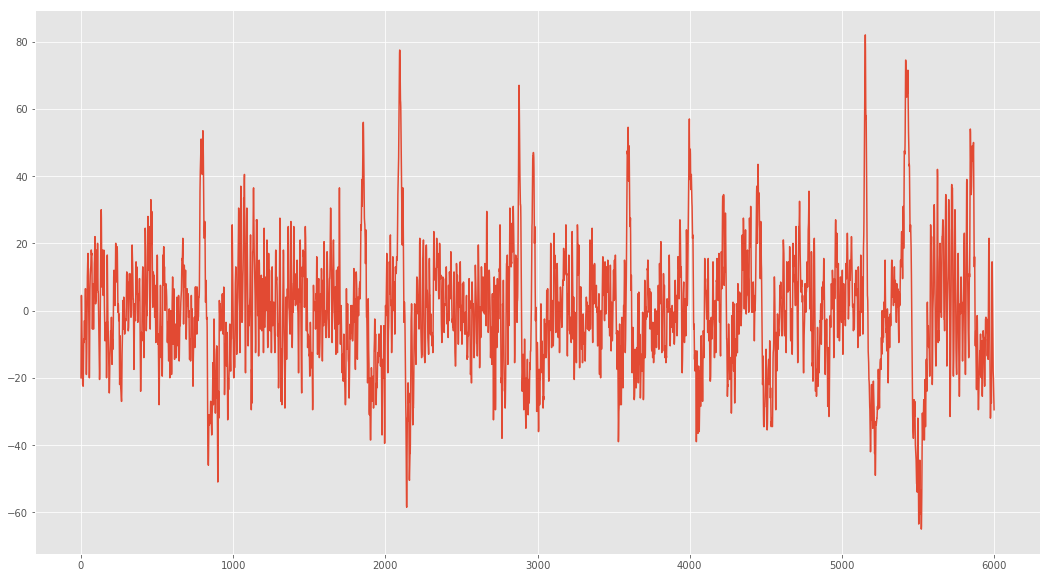

In [5]:
fig, ax = plt.subplots(figsize=(18, 10))
plt.plot(X[0])

## Sub-sampling eeg signal

In [6]:
# sub-sampling
X_sub = X[:, ::6]
print(X_sub.shape)

(10178, 1000)


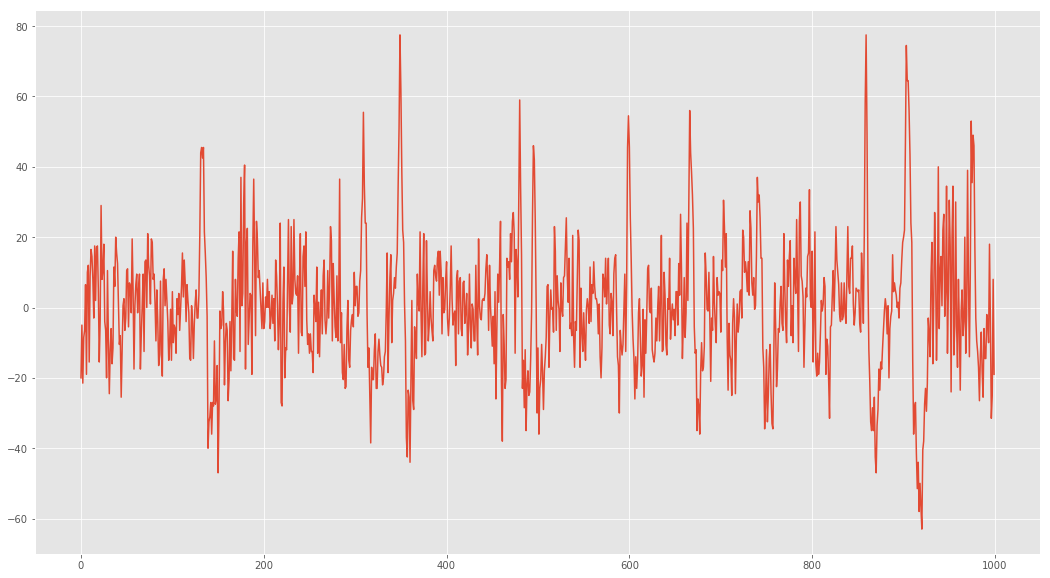

In [7]:
fig, ax = plt.subplots(figsize=(18, 10))
plt.plot(X_sub[0])

## CNN architecture

In [16]:
n, sample_size = X_sub.shape
freq = sample_size/30
win_sec = 3
win_size = int(win_sec * freq)
overlap = 1
overlap_size = int(overlap * freq)
print("%d samples" % n)
print("sampling rate: %.2f Hz" % freq)
print("sample size: %d" % sample_size)
print("window of %d seconds: %d samples" % (win_sec, win_size))
print("overlapping windows of %.2f seconds: %d samples" % (overlap, overlap_size))

num_classes = np.shape(classes)[0]
num_filters = 100
filter_size = win_size
stride = overlap_size

10178 samples
sampling rate: 33.33 Hz
sample size: 1000
window of 3 seconds: 100 samples
overlapping windows of 1.00 seconds: 33 samples


In [18]:
%%time

# placeholders
x_input = tf.placeholder(tf.float32, shape=[None, sample_size], name='x_input')
y_input = tf.placeholder(tf.int64, shape=[None], name='y_input')

with tf.device("/cpu:0"):
    
    # resize time series
    with tf.name_scope("expand"):
        x_expanded = tf.expand_dims(tf.expand_dims(x_input, -1), -1)
    
    # convolution layer
    with tf.name_scope("convolution"):
        filter_shape = [filter_size, 1, 1, num_filters]
        W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name='W')
        b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name='b')
        conv = tf.nn.conv2d(x_expanded,
                            W, 
                            strides=[1, stride, 1, 1],
                            padding='SAME',
                            name='conv')
        # non-linearity
        h = tf.nn.relu(tf.nn.bias_add(conv, b), name='tanh')
        
        # flatten
        output_size = math.ceil(sample_size / stride) * num_filters
        h_flat = tf.reshape(h, [-1, output_size])
        
        # output
        with tf.name_scope("output"):
            W_o = tf.Variable(
                tf.truncated_normal(
                    [output_size, num_classes], stddev=0.1 ), 
                    name='W_o'
            )
            b_o = tf.Variable(tf.constant(0.1, shape=[num_classes]), name='b_o')
            scores = tf.nn.xw_plus_b(h_flat, W_o, b_o, name='scores')
            preds = tf.argmax(scores, 1, name='preds')
        
    init = tf.global_variables_initializer()

CPU times: user 82.4 ms, sys: 4.72 ms, total: 87.1 ms
Wall time: 88.2 ms


In [20]:
%%time
with tf.Session() as sess:
    sess.run(init)
    D = {x_input: X_sub}
    out = sess.run(preds, feed_dict=D)

CPU times: user 2.18 s, sys: 273 ms, total: 2.45 s
Wall time: 1.15 s
